# Seismic Noise Statistics Analysis
Analysis of seismic noise statistics based on

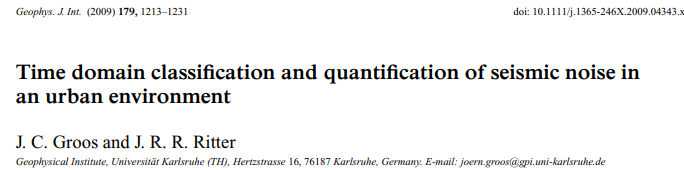

The paper focuses on analyzing urban seismic noise (USN) and introduces several statistical measures to characterize the noise patterns.

### Key Statistical Intervals:


- i68: The 68% interval around the mean
- i95 (or I95.45): The 95.45% interval, corresponding to ±2 standard deviations for a Gaussian distribution
- i99 (or I99.73): The 99.73% interval, corresponding to ±3 standard deviations


### Important Ratios:


- σ2 = I95.45/I68: Ratio between the 95.45% and 68% intervals
- σ3 = I99.73/I68: Ratio between the 99.73% and 68% intervals
- Peak factor (pf) = I99.73/I95.45: Ratio between the 99.73% and 95.45% intervals

### These statistical measures are used to:

- Characterize the distribution of seismic noise
- Identify deviations from Gaussian distribution
- Classify different types of seismic noise signals
- Quantify transient events and periodic signals

### Intervals and ratios are used to develop a classification scheme for urban seismic noise. For a perfectly Gaussian distribution:

- σ2 should equal 2
- σ3 should equal 3
- Peak factor should equal 1.5

Deviations from these values indicate non-Gaussian characteristics in the seismic noise, which can help identify different noise sources and patterns.

In [ ]:
import os
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.filesystem.sds import Client as SDSClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import pandas as pd

# Set global default date formatter
plt.rcParams['date.autoformatter.minute'] = '%Y-%m-%d %H:%M'
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d'
plt.rcParams['date.autoformatter.month'] = '%Y-%m'
plt.rcParams['date.autoformatter.year'] = '%Y'

# Optional: Set additional defaults for better date handling
plt.rcParams['axes.formatter.use_locale'] = True
plt.rcParams['figure.autolayout'] = True  # For better layout with rotated labels


In [ ]:
# Path to where you have copied the DATA/ folder (that contains the SDS, RESP etc folders)
DATA_PATH = "DATA"

## Data Download
Download one day or more days of data from the ORFEUS data center

In [ ]:
# Initialize the ORFEUS client
client = Client("ORFEUS")

# Set the time window for 1 day
starttime = UTCDateTime("2024-02-19")
endtime = starttime + 86400 * 2

# Download data, uncomment the following for running the code
# st = client.get_waveforms(network="BE", station="UCC", location="",
#                          channel="HHZ", starttime=starttime,
#                          endtime=endtime)
# print(f"Downloaded {len(st)} trace(s)")
# print(st)

or just read the files we already have :-)

In [ ]:
client = SDSClient(os.path.join(DATA_PATH, "SDS"))
starttime = UTCDateTime(2024,1,1)
endtime = starttime + 86400 * 2
st = client.get_waveforms(network="8N", station="HB04", location="00", channel="EHZ", starttime=starttime, endtime=endtime)
print(st)

In [ ]:
st.plot();

## Data Preprocessing

In [ ]:
def preprocess_stream(st, freqmin=0.01, freqmax=50):
    """Preprocess the stream: merge, detrend, taper, filter"""
    st_proc = st.copy()
    st_proc.merge(fill_value=0)
    st_proc.detrend('linear')
    st_proc.taper(max_percentage=None, max_length=10)
    st_proc.filter("bandpass", freqmin=freqmin, freqmax=freqmax)
    return st_proc


Pre-filter the traces (bandpass):

In [ ]:
freqmin = 1.0
freqmax = 50.0

st_proc = preprocess_stream(st, freqmin=freqmin, freqmax=freqmax)

## Statistical Analysis

In [ ]:
def calculate_intervals(data):
    """Calculate the statistical intervals and ratios"""
    # Calculate percentiles
    p16, p84 = np.percentile(data, [16, 84])
    p2_275, p97_725 = np.percentile(data, [2.275, 97.725])
    p0_135, p99_865 = np.percentile(data, [0.135, 99.865])
    
    # Calculate intervals
    i68 = p84 - p16
    i95 = p97_725 - p2_275
    i99 = p99_865 - p0_135
    
    # Calculate ratios
    sigma2 = i95/i68
    sigma3 = i99/i68
    peak_factor = i99/i95
    
    # Calculate symmetry measures
    si68 = abs(p84/p16)
    si95 = abs(p97_725/p2_275)
    
    return {
        'i68': i68,
        'i95': i95,
        'i99': i99,
        'sigma2': sigma2,
        'sigma3': sigma3,
        'peak_factor': peak_factor,
        'si68': si68,
        'si95': si95
    }

# Split data into 4-hour windows
def split_data(st, window_seconds=4):
    """Split data into windows and calculate statistics for each"""
    trace = st[0]
    sampling_rate = trace.stats.sampling_rate
    samples_per_window = int(window_seconds * sampling_rate)
    
    results = []
    for i in range(0, len(trace.data), samples_per_window):
        window = trace.data[i:i+samples_per_window]
        if len(window) == samples_per_window:  # Only process complete windows
            stats = calculate_intervals(window)
            stats['start_time'] = trace.stats.starttime + i/sampling_rate
            
            results.append(stats)
    df = pd.DataFrame(results)
    df.index = [dt.datetime for dt in df['start_time'].apply(UTCDateTime)]
    return df

stats_df = split_data(st_proc, window_seconds=60)
print(stats_df.head())

## Visualization

In [ ]:
plt.figure(figsize=(15, 5))

# Plot each interval using the converted dates
plt.plot(stats_df.index, stats_df['i68'], 'b-', label='i68')
plt.plot(stats_df.index, stats_df['i95'], 'g-', label='i95')
plt.plot(stats_df.index, stats_df['i99'], 'r-', label='i99')

# Customize the plot
plt.title('Raw Interval Values')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

# Plot sigma2 ratio
plt.subplot(3, 1, 1)
plt.plot(stats_df.index, stats_df['sigma2'], 'b-')
plt.axhline(y=2, color='r', linestyle='--', label='Gaussian Reference')
plt.title('σ2 Ratio (I95/I68)')
plt.legend()

# Plot sigma3 ratio
plt.subplot(3, 1, 2)
plt.plot(stats_df.index, stats_df['sigma3'], 'g-')
plt.axhline(y=3, color='r', linestyle='--', label='Gaussian Reference')
plt.title('σ3 Ratio (I99/I68)')
plt.legend()

# Plot peak factor
plt.subplot(3, 1, 3)
plt.plot(stats_df.index, stats_df['peak_factor'], 'r-')
plt.axhline(y=1.5, color='r', linestyle='--', label='Gaussian Reference')
plt.title('Peak Factor (I99/I95)')
plt.legend()

plt.tight_layout()
plt.show()

## Noise Classification

### NC1 (Gaussian): 
    - Almost perfectly Gaussian distributed noise
    - σ2 ≈ 2 (±0.05), σ3 ≈ 3 (±0.15), peak factor ≈ 1.5 (±0.1)
    - Indicates well-mixed noise from multiple sources

### NC2 (Near-Gaussian):
    - Small deviations from Gaussian
    - Peak factor remains close to 1.5 (±0.1)
    - Common in natural seismic background noise

### NC3 (Moderate Positive Kurtosis):
    - Peak factor between 1.5 and 2
    - Indicates presence of occasional transient signals
    - Common during periods of moderate human activity

### NC4 (Strong Positive Kurtosis):
    - Peak factor > 2
    - Shows strong presence of transient signals
    - Typical during periods of intense human activity or nearby events

### NC5 (Negative Kurtosis):
    - Peak factor < 1.4
    - Often indicates presence of periodic signals
    - Can be caused by machinery or continuous vibration sources

### NC6 (Asymmetric):
    - Significant asymmetry in the distribution
    - |1 - SI68| > 0.03 or |1 - SI95| > 0.047
    - Can indicate nearby unilateral noise sources

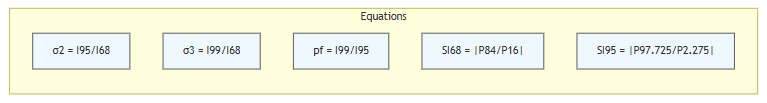
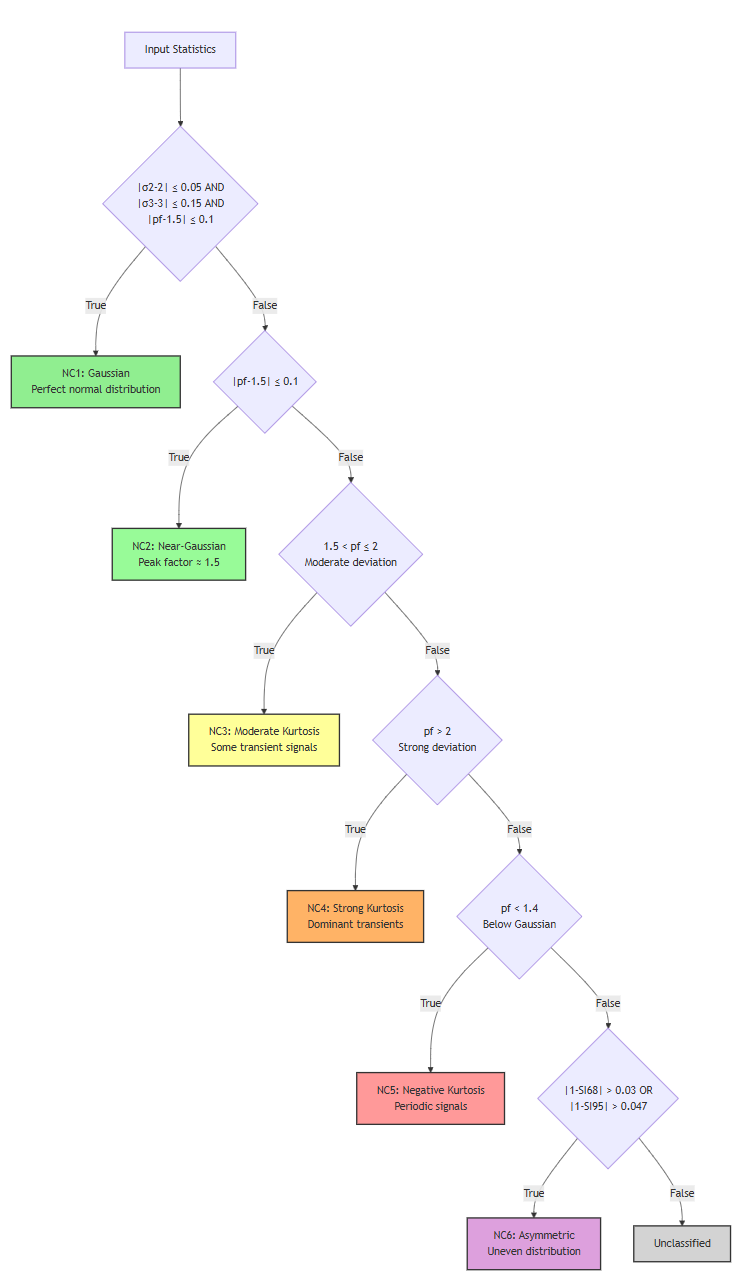

In [ ]:
# Enhanced classification code with time plot:
def classify_noise(stats):
    """
    Classify noise based on the paper criteria
    Returns: class label and detailed reason for classification
    """
    if (abs(stats['sigma2'] - 2) <= 0.05 and 
        abs(stats['sigma3'] - 3) <= 0.15 and
        abs(stats['peak_factor'] - 1.5) <= 0.1):
        return 'NC1', 'Gaussian'
    elif (abs(stats['peak_factor'] - 1.5) <= 0.1):
        return 'NC2', 'Near-Gaussian'
    elif (1.5 < stats['peak_factor'] <= 2):
        return 'NC3', 'Moderate Kurtosis'
    elif (stats['peak_factor'] > 2):
        return 'NC4', 'Strong Kurtosis'
    elif (stats['peak_factor'] < 1.4):
        return 'NC5', 'Negative Kurtosis'
    elif (abs(1 - stats['si68']) > 0.03 or abs(1 - stats['si95']) > 0.047):
        return 'NC6', 'Asymmetric'
    else:
        return 'Unclassified', 'Does not match criteria'

# Apply classification and store both class and reason
stats_df[['noise_class', 'classification_reason']] = pd.DataFrame(
    [classify_noise(row) for _, row in stats_df.iterrows()], 
    index=stats_df.index
)

# Print overall statistics
print("Noise Class Distribution:")
class_dist = stats_df['noise_class'].value_counts().sort_index()
for nc in class_dist.index:
    print(f"{nc}: {class_dist[nc]} windows ({(class_dist[nc]/len(stats_df)*100):.1f}%)")


In [ ]:
# Create a visualization of noise classes over time
plt.figure(figsize=(15, 8))

# Create a scatter plot where y-axis is categorical (noise classes)
# Convert noise classes to numeric for colormap
class_to_num = {f'NC{i}':i for i in range(1,7)}
colors = [class_to_num[cls] for cls in stats_df['noise_class']]
plt.scatter(stats_df.index, colors, 
           c=colors, cmap="viridis",
           s=100, alpha=0.6)
plt.yticks(range(1,7) ,class_to_num.keys())

plt.title('Evolution of Noise Classes Over Time')
plt.xlabel('Time')
plt.ylabel('Noise Class')
plt.grid(True, alpha=0.3)

# Add a text box with class descriptions
desc_text = "NC1: Gaussian\nNC2: Near-Gaussian\nNC3: Moderate Kurtosis (Some Transients)\n" \
           "NC4: Strong Kurtosis (Dominant Transients)\nNC5: Negative Kurtosis (Periodic Signals)\nNC6: Asymmetric (Uneven Distribution)"
plt.text(1.02, 0.5, desc_text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='center')

plt.tight_layout()
plt.show()

# Relationship between peak factor and classification

In [ ]:
definitions = {
    "NC1": "NC1: Gaussian",
    "NC2": "NC2: Near-Gaussian",
    "NC3": "NC3: Moderate Kurtosis (Some Transients)",
    "NC4": "NC4: Strong Kurtosis (Dominant Transients)",
    "NC5": "NC5: Negative Kurtosis (Periodic Signals)",
    "NC6": "NC6: Asymmetric (Uneven Distribution)"
}

plt.figure(figsize=(15, 5))
for nc in sorted(stats_df['noise_class'].unique()):
    mask = stats_df['noise_class'] == nc
    plt.scatter(stats_df.index[mask], stats_df[mask]['peak_factor'], 
               label=definitions[nc], alpha=0.6)

plt.axhline(y=1.5, color='k', linestyle='--', alpha=0.3, label='Gaussian Reference')
plt.title('Peak Factor Values by Noise Class')
plt.xlabel('Time')
plt.ylabel('Peak Factor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()